# Clustering de documents

## Imports

In [1]:
# Imports essentiels
import os
import string
import re
import collections
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import FrenchStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

# Downloads nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Configuration corpus
data_path = "../../data/txt_tp4/"


[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# tous les fichiers .txt
files = sorted([f for f in os.listdir(data_path) if f.endswith(".txt")])

# on charge les textes
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read()
         for f in files]

print("Nombre de documents chargés :", len(texts))


Nombre de documents chargés : 999


In [23]:
# Filtrer les articles contenant “sorcière” + (femm ou fémin)**

def matches_query(text):
    text_lower = text.lower()
    cond1 = "sorcière" in text_lower or "sorciere" in text_lower
    cond2 = bool(re.search(r"\bfemm\w*|\bfémin\w*", text_lower))
    return cond1 and cond2

filtered_files = []
filtered_texts = []

for f, t in zip(files, texts):
    if matches_query(t):
        filtered_files.append(f)
        filtered_texts.append(t)

print("Articles correspondant à la requête :", len(filtered_texts))


Articles correspondant à la requête : 993


In [39]:
stemmer = FrenchStemmer()

def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\d+", " ", text)               # supprimer nombres
    text = re.sub(r"[^\w\s]", " ", text)          # supprimer ponctuation
    text = re.sub(r"\s+", " ", text)              # espace unique
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]    # supprimer tokens courts
    tokens = [stemmer.stem(t) for t in tokens]    # racinisation
    return tokens

# Test rapide
print(preprocessing(clean_texts[0])[:20])


['samed', 'janvi', 'som', 'conseil', 'guerr', 'bruxel', 'proces', 'von', 'falkenhausen', 'audienc', 'vendred', 'rolin', 'poursuiv', 'répliqu', 'trait', 'question', 'juiv', 'soulign', 'le', 'dizain']


## TF-IDF sur les textes filtrés

In [40]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words("french") + ["comme","ainsi","cela","cette","etc"],
    min_df=3,
    max_df=0.4
)

tfidf_vectors = vectorizer.fit_transform(clean_texts)
print("Shape TF-IDF :", tfidf_vectors.shape)


/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ains', 'aur', 'aurion', 'auron', 'avi', 'avion', 'avon', 'ayon', 'cel', 'cet', 'comm', 'dan', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'mêm', 'notr', 'ser', 'serion', 'seron', 'soi', 'somm', 'soyon', 'votr', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Shape TF-IDF : (320, 16384)


### Clustering KMeans

### Regrouper les fichiers par cluster

In [41]:
N_CLUSTERS = 3
km_model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = km_model.fit_predict(tfidf_vectors)

# Regrouper fichiers par cluster
clustering = collections.defaultdict(list)
for idx, label in enumerate(clusters):
    clustering[label].append(clean_files[idx])

pprint(dict(clustering))


{0: ['KB_JB838_1951-01-20_01-00005.txt',
     'KB_JB838_1951-02-04_01-00020.txt',
     'KB_JB838_1951-05-11_01-00002.txt',
     'KB_JB838_1951-06-09_01-00001.txt',
     'KB_JB838_1951-08-10_01-00014.txt',
     'KB_JB838_1952-03-22_01-00006.txt',
     'KB_JB838_1952-07-26_01-00005.txt',
     'KB_JB838_1952-10-09_01-00002.txt',
     'KB_JB838_1953-01-10_01-00006.txt',
     'KB_JB838_1953-01-24_01-00007.txt',
     'KB_JB838_1953-03-29_01-00006.txt',
     'KB_JB838_1953-04-24_01-00018.txt',
     'KB_JB838_1953-07-31_01-00014.txt',
     'KB_JB838_1953-09-05_01-00007.txt',
     'KB_JB838_1953-09-12_01-00007.txt',
     'KB_JB838_1953-11-12_01-00004.txt',
     'KB_JB838_1954-02-05_01-00016.txt',
     'KB_JB838_1954-03-05_01-00005.txt',
     'KB_JB838_1954-03-15_01-00010.txt',
     'KB_JB838_1954-03-27_01-00002.txt',
     'KB_JB838_1954-06-25_01-00002.txt',
     'KB_JB838_1954-07-17_01-00007.txt',
     'KB_JB838_1954-08-14_01-00007.txt',
     'KB_JB838_1954-09-17_01-00016.txt',
     'KB_JB838_1

### Extraire les mots caractéristiques de chaque cluster

In [42]:
centers = km_model.cluster_centers_
terms = vectorizer.get_feature_names_out()

N_TOP = 20
cluster_keywords = {}

for i in range(N_CLUSTERS):
    top_idx = centers[i].argsort()[-N_TOP:][::-1]
    cluster_keywords[i] = [(terms[j], float(centers[i][j])) for j in top_idx] 

pprint(cluster_keywords)


{0: [('ministr', 0.02626044397739629),
     ('président', 0.025782992699717663),
     ('écrivain', 0.01836961938196645),
     ('poet', 0.017557551940312936),
     ('poes', 0.017494370899106878),
     ('gouvern', 0.0170637235397774),
     ('ouvrag', 0.016644786125656254),
     ('edit', 0.014862458453178785),
     ('exposit', 0.014807650558615796),
     ('professeur', 0.013525877273774968),
     ('littérair', 0.013016548845950982),
     ('lecteur', 0.012811673422978436),
     ('sant', 0.01245642486416524),
     ('étudi', 0.012426808989280527),
     ('dram', 0.01242129794158152),
     ('ballet', 0.012220113785613114),
     ('loi', 0.012199718258466207),
     ('enseign', 0.01217684036138772),
     ('rec', 0.012036638782932133),
     ('directeur', 0.011962166855191554)],
 1: [('concert', 0.14442139964047496),
     ('magazin', 0.07610383054149635),
     ('aff', 0.0740949235769284),
     ('symphon', 0.07169249239511129),
     ('feuilleton', 0.06775290257885228),
     ('theatr', 0.066709960951

## Comprendre le cluster et leurs thematiques

### Barplots : visualisation quantitative des mots-clés

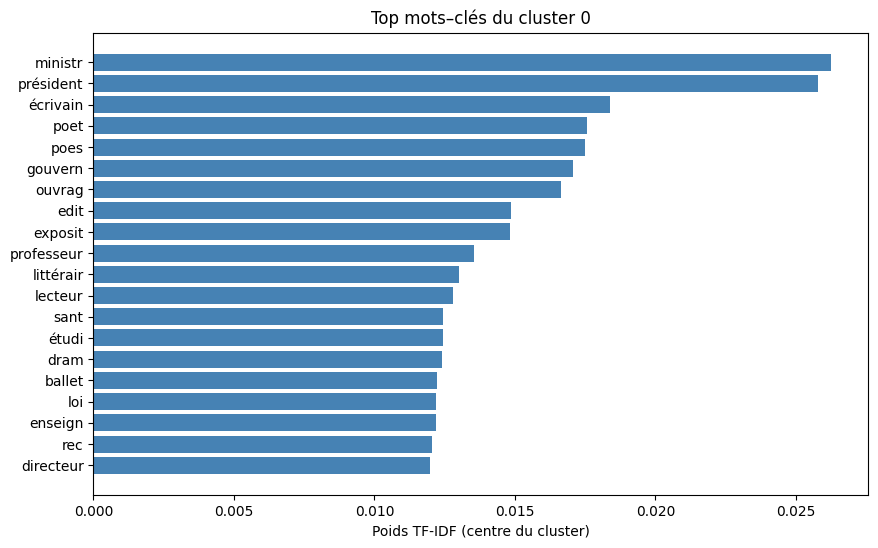

In [43]:
def plot_cluster_keywords(cluster_keywords, cluster_id):
    # extraire uniquement mots et scores simples
    pairs = cluster_keywords[cluster_id]
    words = [w for w, s in pairs]
    scores = [s for w, s in pairs]

    plt.figure(figsize=(10, 6))
    plt.barh(words[::-1], scores[::-1], color="steelblue")
    plt.title(f"Top mots–clés du cluster {cluster_id}")
    plt.xlabel("Poids TF-IDF (centre du cluster)")
    plt.show()

plot_cluster_keywords(cluster_keywords, 0)


### Nouage de mots

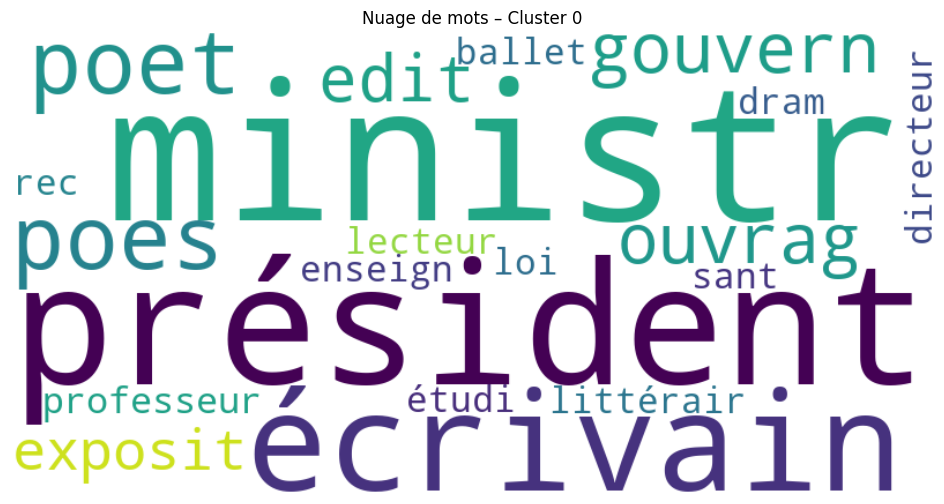

In [44]:
from wordcloud import WordCloud

def plot_wordcloud(cluster_keywords, cluster_id):
    # créer dictionnaire {mot: score}
    freq = {word: score for word, score in cluster_keywords[cluster_id]}
    
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(freq)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots – Cluster {cluster_id}")
    plt.show()

# Exemple : cluster 0
plot_wordcloud(cluster_keywords, 0)


### Résuler les thématiques via topic-embedding PCA

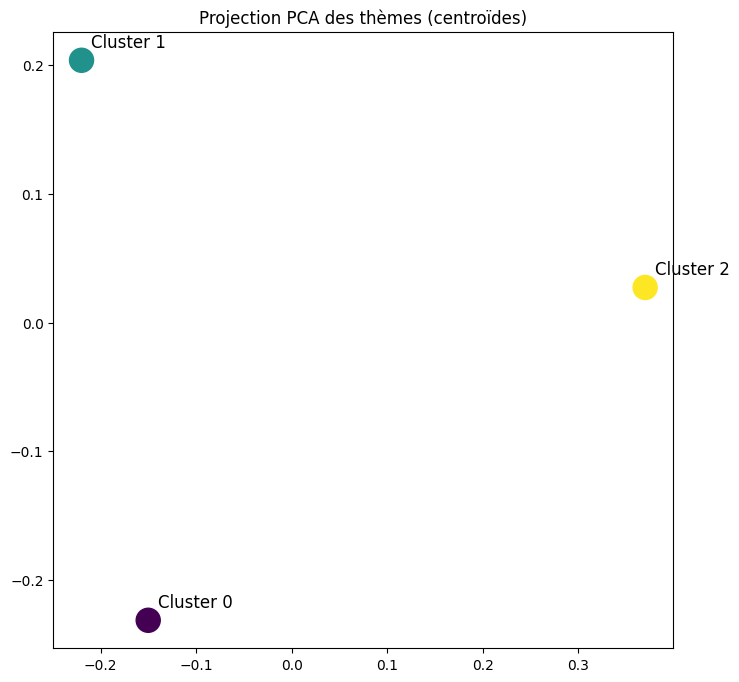

In [45]:
# Cette carte montre la position thématique globale de chaque cluster
ca = PCA(n_components=2)
cluster_points = pca.fit_transform(km_model.cluster_centers_)

plt.figure(figsize=(8,8))
plt.scatter(cluster_points[:,0], cluster_points[:,1], s=300, c=range(N_CLUSTERS))

for i, (x,y) in enumerate(cluster_points):
    plt.text(x+0.01, y+0.01, f"Cluster {i}", fontsize=12)

plt.title("Projection PCA des thèmes (centroïdes)")
plt.show()


### Explorer les mots les plus discriminants entre clusters

In [46]:
# gébérer des mots-clés avec scores
km_model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = km_model.fit_predict(tfidf_vectors)


# extraction des mots clés avec scores

centers = km_model.cluster_centers_
terms = vectorizer.get_feature_names_out()

cluster_keywords = {}
N_TOP = 20

for i in range(N_CLUSTERS):
    idx = centers[i].argsort()[-N_TOP:][::-1]
    # Chaque cluster devient une liste de tuples (mot, score)
    cluster_keywords[i] = [(terms[j], centers[i][j]) for j in idx]

print("\nMots-clés par cluster (avec scores) :")
pprint(cluster_keywords)



Mots-clés par cluster (avec scores) :
{0: [('ministr', 0.02626044397739629),
     ('président', 0.025782992699717663),
     ('écrivain', 0.01836961938196645),
     ('poet', 0.017557551940312936),
     ('poes', 0.017494370899106878),
     ('gouvern', 0.0170637235397774),
     ('ouvrag', 0.016644786125656254),
     ('edit', 0.014862458453178785),
     ('exposit', 0.014807650558615796),
     ('professeur', 0.013525877273774968),
     ('littérair', 0.013016548845950982),
     ('lecteur', 0.012811673422978436),
     ('sant', 0.01245642486416524),
     ('étudi', 0.012426808989280527),
     ('dram', 0.01242129794158152),
     ('ballet', 0.012220113785613114),
     ('loi', 0.012199718258466207),
     ('enseign', 0.01217684036138772),
     ('rec', 0.012036638782932133),
     ('directeur', 0.011962166855191554)],
 1: [('concert', 0.14442139964047496),
     ('magazin', 0.07610383054149635),
     ('aff', 0.0740949235769284),
     ('symphon', 0.07169249239511129),
     ('feuilleton', 0.06775290257

In [47]:
# fonction discriminante
disc_words = discriminant_words(cluster_keywords)
pprint(disc_words)


{0: [('ministr', 0.02626044397739629),
     ('président', 0.025782992699717663),
     ('écrivain', 0.01836961938196645),
     ('poet', 0.017557551940312936),
     ('poes', 0.017494370899106878),
     ('gouvern', 0.0170637235397774),
     ('ouvrag', 0.016644786125656254),
     ('edit', 0.014862458453178785),
     ('exposit', 0.014807650558615796),
     ('professeur', 0.013525877273774968),
     ('littérair', 0.013016548845950982),
     ('lecteur', 0.012811673422978436),
     ('étudi', 0.012426808989280527),
     ('dram', 0.01242129794158152),
     ('ballet', 0.012220113785613114)],
 1: [('concert', 0.14442139964047496),
     ('magazin', 0.07610383054149635),
     ('aff', 0.0740949235769284),
     ('symphon', 0.07169249239511129),
     ('feuilleton', 0.06775290257885228),
     ('jazz', 0.06434546743543676),
     ('disqu', 0.06125871948139342),
     ('scolair', 0.06106944807113965),
     ('luxembourg', 0.06003515113168049),
     ('actual', 0.05634532013420614),
     ('chain', 0.0563139859

In [48]:
# verification
cluster_keywords[0][:8]


[('ministr', 0.02626044397739629),
 ('président', 0.025782992699717663),
 ('écrivain', 0.01836961938196645),
 ('poet', 0.017557551940312936),
 ('poes', 0.017494370899106878),
 ('gouvern', 0.0170637235397774),
 ('ouvrag', 0.016644786125656254),
 ('edit', 0.014862458453178785)]

In [49]:
# Par exemple : quels mots distinguent vraiment un cluster des autres ?
import numpy as np

def discriminant_words(cluster_keywords):
    all_words = set(word for cluster in cluster_keywords.values() for word, _ in cluster)
    discriminant = {}
    
    for i in range(N_CLUSTERS):
        weights_i = {w: s for w, s in cluster_keywords[i]}
        discriminant[i] = []
        
        for word in all_words:
            score_i = weights_i.get(word, 0)
            score_others = np.mean([
                {w: s for w, s in cluster_keywords[j]}.get(word, 0)
                for j in range(N_CLUSTERS) if j != i
            ])
            discriminant[i].append((word, score_i - score_others))
        
        discriminant[i] = sorted(discriminant[i], key=lambda x: x[1], reverse=True)[:15]
    
    return discriminant

disc_words = discriminant_words(cluster_keywords)
pprint(disc_words)


{0: [('ministr', 0.02626044397739629),
     ('président', 0.025782992699717663),
     ('écrivain', 0.01836961938196645),
     ('poet', 0.017557551940312936),
     ('poes', 0.017494370899106878),
     ('gouvern', 0.0170637235397774),
     ('ouvrag', 0.016644786125656254),
     ('edit', 0.014862458453178785),
     ('exposit', 0.014807650558615796),
     ('professeur', 0.013525877273774968),
     ('littérair', 0.013016548845950982),
     ('lecteur', 0.012811673422978436),
     ('étudi', 0.012426808989280527),
     ('dram', 0.01242129794158152),
     ('ballet', 0.012220113785613114)],
 1: [('concert', 0.14442139964047496),
     ('magazin', 0.07610383054149635),
     ('aff', 0.0740949235769284),
     ('symphon', 0.07169249239511129),
     ('feuilleton', 0.06775290257885228),
     ('jazz', 0.06434546743543676),
     ('disqu', 0.06125871948139342),
     ('scolair', 0.06106944807113965),
     ('luxembourg', 0.06003515113168049),
     ('actual', 0.05634532013420614),
     ('chain', 0.0563139859

### Obtenir les articles les plus représentatifs de chaque cluster

In [50]:
tfidf_array = tfidf_vectors.toarray()

repr_docs = {}

for c in range(N_CLUSTERS):
    distances = cosine_distances(tfidf_array, centers[c].reshape(1, -1)).reshape(-1)
    closest = distances.argsort()[:5]
    repr_docs[c] = [filtered_files[i] for i in closest]

pprint(repr_docs)


{0: ['KB_JB838_1952-03-22_01-00016.txt',
     'KB_JB838_1954-05-16_01-00010.txt',
     'KB_JB838_1954-06-20_01-00011.txt',
     'KB_JB838_1954-03-11_01-00014.txt',
     'KB_JB838_1951-04-06_01-00007.txt'],
 1: ['KB_JB838_1956-11-07_01-00012.txt',
     'KB_JB838_1956-10-26_01-00002.txt',
     'KB_JB838_1956-11-06_01-00010.txt',
     'KB_JB838_1956-10-18_01-00010.txt',
     'KB_JB838_1956-11-11_01-00010.txt'],
 2: ['KB_JB838_1952-04-08_01-00008.txt',
     'KB_JB838_1954-11-05_01-00010.txt',
     'KB_JB838_1952-03-22_01-00006.txt',
     'KB_JB838_1954-03-02_01-00009.txt',
     'KB_JB838_1954-02-11_01-00010.txt']}


### Visualisation en 2D (PCA)

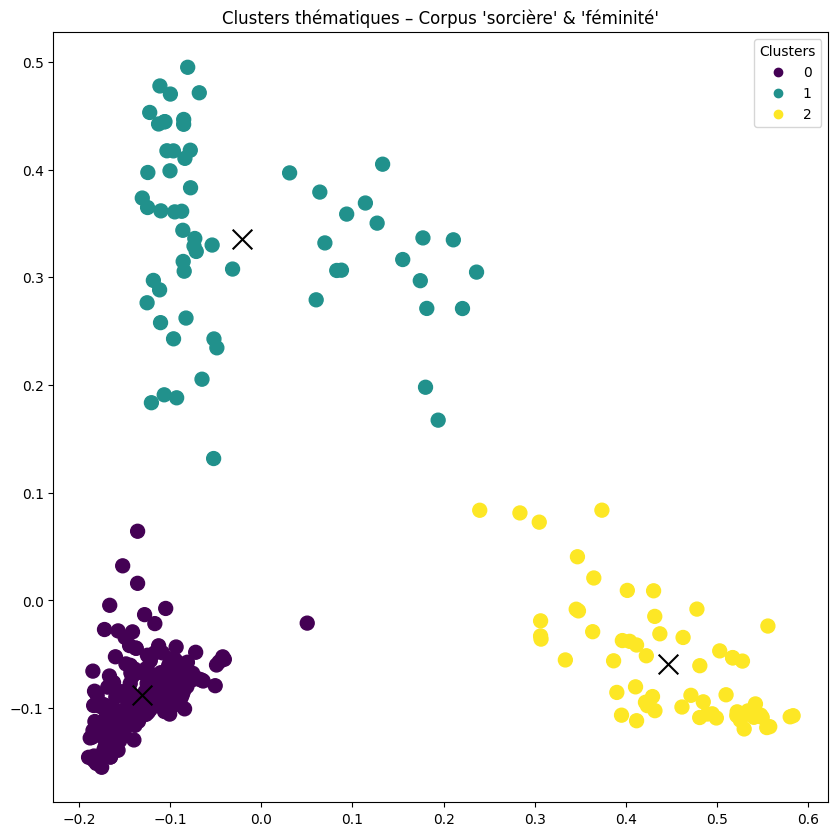

In [51]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_array)

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# centroides
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=200, color="black")

plt.title("Clusters thématiques – Corpus 'sorcière' & 'féminité'")
plt.legend(handles=scatter.legend_elements()[0],
           labels=set(clusters),
           title="Clusters")
plt.show()


## Nuage de mots par cluster

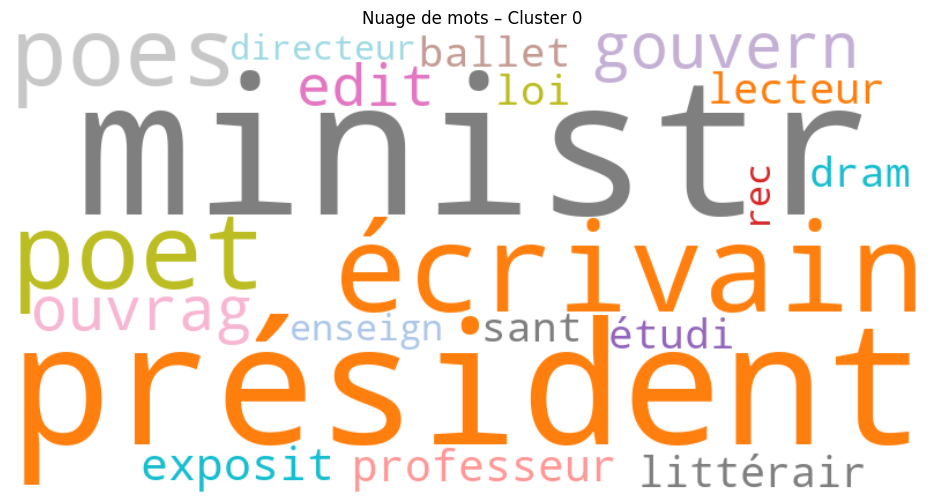

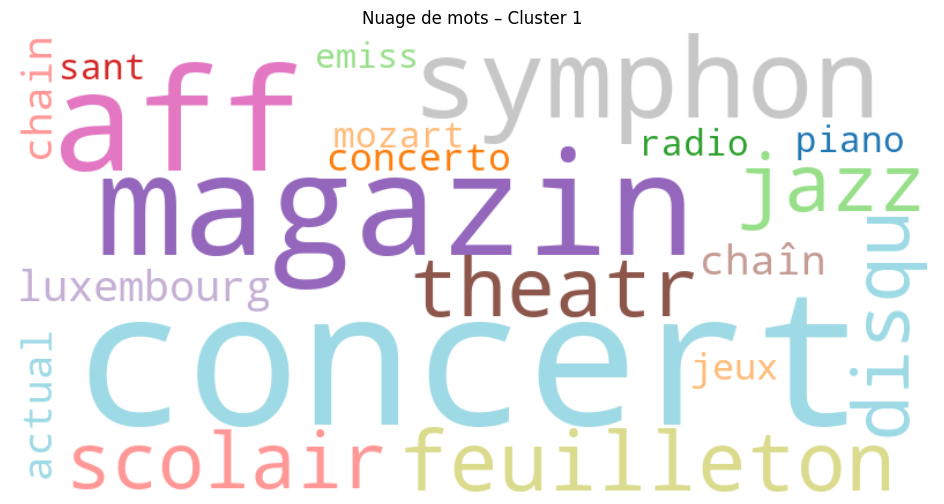

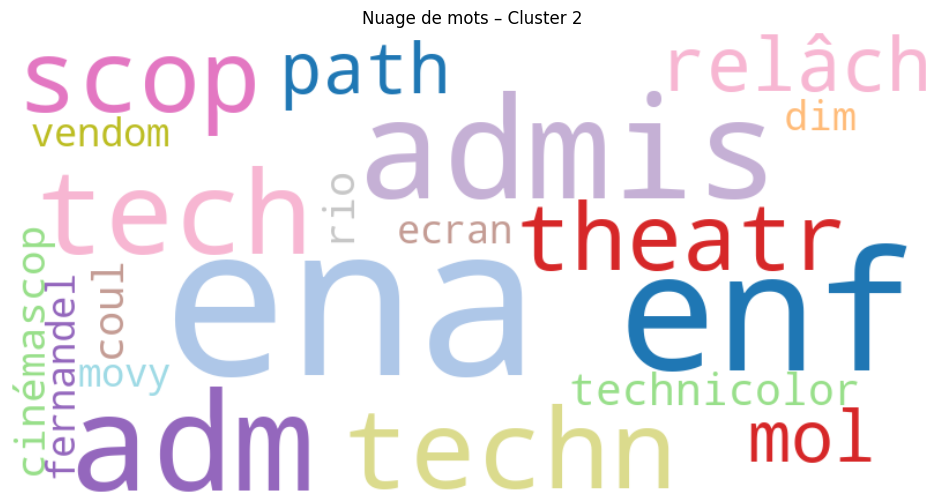

KeyError: 3

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud_cluster(cluster_id, top_n=50):
    """
    Affiche un nuage de mots pour un cluster donné.
    cluster_id : numéro du cluster
    top_n : nombre de mots les plus importants à afficher
    """
    # récupérer les mots et scores du centre du cluster
    pairs = cluster_keywords[cluster_id][:top_n]
    freq = {word: float(score) for word, score in pairs}  # clé=mot, valeur=TF-IDF

    wc = WordCloud(width=800, height=400, background_color="white", colormap="tab20")
    wc.generate_from_frequencies(freq)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots – Cluster {cluster_id}")
    plt.show()

# Exemple : cluster 0, 1 et 2
plot_wordcloud_cluster(0)
plot_wordcloud_cluster(1)
plot_wordcloud_cluster(2)
plot_wordcloud_cluster(3)





In [38]:
# importante pour contouer analuyse avec ner
import pickle

data_to_export = {
    "clean_texts": clean_texts,
    "clean_files": clean_files,
    "clusters": clusters,
    "N_CLUSTERS": N_CLUSTERS,
}

with open("clustering_results.pkl", "wb") as f:
    pickle.dump(data_to_export, f)

print("Fichier clustering_results.pkl sauvegardé.")


Fichier clustering_results.pkl sauvegardé.


# continuation

 999 documents chargés.
✅ Articles correspondant à la requête : 993
 Documents après suppression du bruit : 320


/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ains', 'aur', 'aurion', 'auron', 'avi', 'avion', 'avon', 'ayon', 'cel', 'cet', 'comm', 'dan', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'mêm', 'notr', 'ser', 'serion', 'seron', 'soi', 'somm', 'soyon', 'votr', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


✅ TF-IDF : 320 docs × 16384 features
{0: ['KB_JB838_1951-01-20_01-00005.txt',
     'KB_JB838_1951-05-11_01-00002.txt',
     'KB_JB838_1951-06-09_01-00001.txt',
     'KB_JB838_1952-07-26_01-00005.txt',
     'KB_JB838_1952-10-09_01-00002.txt',
     'KB_JB838_1953-03-29_01-00006.txt',
     'KB_JB838_1953-11-12_01-00004.txt',
     'KB_JB838_1954-03-15_01-00010.txt',
     'KB_JB838_1954-03-27_01-00002.txt',
     'KB_JB838_1954-06-25_01-00002.txt',
     'KB_JB838_1954-11-17_01-00005.txt',
     'KB_JB838_1954-11-24_01-00003.txt',
     'KB_JB838_1955-03-26_01-00002.txt',
     'KB_JB838_1955-06-15_01-00005.txt',
     'KB_JB838_1955-09-09_01-00002.txt',
     'KB_JB838_1955-10-12_01-00007.txt',
     'KB_JB838_1955-11-01_01-00005.txt',
     'KB_JB838_1955-12-21_01-00005.txt',
     'KB_JB838_1956-02-06_01-00003.txt',
     'KB_JB838_1956-04-18_01-00005.txt',
     'KB_JB838_1956-04-23_01-00002.txt',
     'KB_JB838_1956-10-05_01-00003.txt',
     'KB_JB838_1956-12-07_01-00005.txt',
     'KB_JB838_1957-

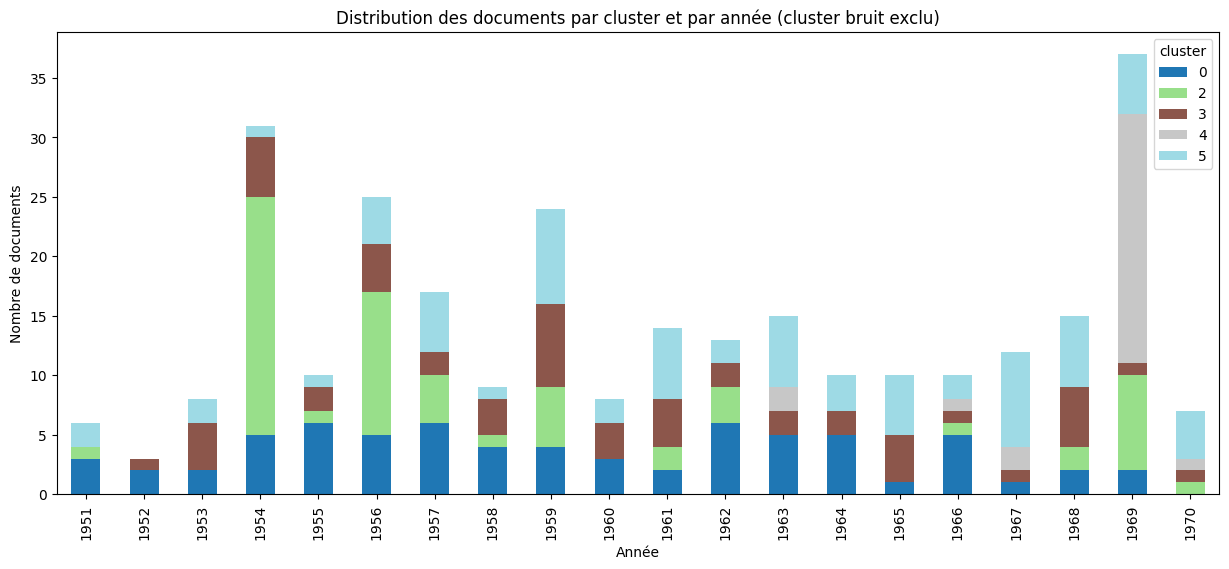

In [22]:
# ============================
# Imports essentiels
# ============================
import os
import re
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

from wordcloud import WordCloud
from pprint import pprint

# Downloads nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# ============================
# 1️ Chargement et filtrage
# ============================
data_path = "../../data/txt_tp4/"
files = sorted([f for f in os.listdir(data_path) if f.endswith(".txt")])
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read() for f in files]

print(f" {len(texts)} documents chargés.")

# Filtre mots-clés : "sorcière" + féminité
def matches_query(text):
    text_lower = text.lower()
    cond1 = "sorcière" in text_lower or "sorciere" in text_lower
    cond2 = bool(re.search(r"\bfemm\w*|\bfémin\w*", text_lower))
    return cond1 and cond2

filtered_files = []
filtered_texts = []

for f, t in zip(files, texts):
    if matches_query(t):
        filtered_files.append(f)
        filtered_texts.append(t)

print(f"✅ Articles correspondant à la requête : {len(filtered_texts)}")

# Filtrer documents "bruit"
def is_noise(text):
    # trop de chiffres → petites annonces
    if len(re.findall(r"\d{3,}", text)) > 30:
        return True
    # trop d'heures ou dates → programmes radio/tv
    if len(re.findall(r"\b\d{2}h\d{2}\b|\b\d{4}\b", text)) > 20:
        return True
    return False

clean_files = []
clean_texts = []

for f, t in zip(filtered_files, filtered_texts):
    if not is_noise(t):
        clean_files.append(f)
        clean_texts.append(t)

print(f" Documents après suppression du bruit : {len(clean_texts)}")

# ============================
# 2️⃣ Prétraitement / TF-IDF
# ============================
stemmer = FrenchStemmer()

def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words("french") + ["comme","ainsi","cela","cette","etc"],
    min_df=3,
    max_df=0.4
)
tfidf_vectors = vectorizer.fit_transform(clean_texts)
print(f"✅ TF-IDF : {tfidf_vectors.shape[0]} docs × {tfidf_vectors.shape[1]} features")

# ============================
# 3️⃣ Clustering KMeans
# ============================
N_CLUSTERS = 6
km_model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = km_model.fit_predict(tfidf_vectors)

# Regrouper fichiers par cluster
clustering = collections.defaultdict(list)
for idx, label in enumerate(clusters):
    clustering[label].append(clean_files[idx])
pprint(dict(clustering))

# ============================
# 4️⃣ Extraction des mots-clés par cluster
# ============================
centers = km_model.cluster_centers_
terms = vectorizer.get_feature_names_out()
N_TOP = 20

cluster_keywords = {}
for i in range(N_CLUSTERS):
    idx = centers[i].argsort()[-N_TOP:][::-1]
    cluster_keywords[i] = [(terms[j], float(centers[i][j])) for j in idx]

# Visualisation rapide cluster 0
print("\nCluster 0 top mots :")
pprint(cluster_keywords[0])

# ============================
# 5️⃣ Suppression du cluster "bruit" identifié (ex: cluster 1)
# ============================
mask = clusters != 1  # supposer cluster 1 = bruit
clean_files_filtered = [f for f, m in zip(clean_files, mask) if m]
clean_texts_filtered = [t for t, m in zip(clean_texts, mask) if m]
tfidf_vectors_filtered = tfidf_vectors[mask]
clusters_filtered = clusters[mask]

print(f"✅ Après suppression du cluster bruit : {len(clean_texts_filtered)} documents")

# ============================
# 6️⃣ Passages représentatifs par cluster
# ============================
tfidf_array = tfidf_vectors_filtered.toarray()
repr_docs = {}

for c in range(N_CLUSTERS):
    if c == 1:  # cluster bruit ignoré
        continue
    distances = cosine_distances(tfidf_array, km_model.cluster_centers_[c].reshape(1, -1)).reshape(-1)
    closest_idx = distances.argsort()[:5]
    repr_docs[c] = [(clean_files_filtered[i], clean_texts_filtered[i][:300]) for i in closest_idx]

# Affichage passages représentatifs
for c in repr_docs:
    print(f"\n--- Cluster {c} ---")
    for f, snippet in repr_docs[c]:
        print(f"{f}: {snippet}...\n")

# ============================
# 7️⃣ Analyse temporelle
# ============================
years = []
for f in clean_files_filtered:
    match = re.search(r"(\d{4})", f)
    if match:
        years.append(int(match.group(1)))
    else:
        years.append(None)

df = pd.DataFrame({
    "file": clean_files_filtered,
    "cluster": clusters_filtered,
    "year": years
})

# Comptage documents par cluster et année
timeline = df.groupby(["cluster","year"]).size().unstack(fill_value=0)

# Filtrer années avec très peu de documents pour lisibilité
timeline_filtered = timeline.loc[:, timeline.sum() > 2]

# Visualisation
timeline_filtered.T.plot(kind="bar", stacked=True, figsize=(15,6), colormap="tab20")
plt.title("Distribution des documents par cluster et par année (cluster bruit exclu)")
plt.xlabel("Année")
plt.ylabel("Nombre de documents")
plt.show()



--- Cluster 0 : Top entités ---
[('Bruxelles', 238),
 ('M', 212),
 ('Belgique', 173),
 ('I', 152),
 ('Paris', 141),
 ('Etat', 118),
 ('U', 116),
 ('A', 106),
 ('P', 105),
 ('Angleterre', 72),
 ('Moscou', 63),
 ('France', 60),
 ('H', 59),
 ('Allemagne', 58),
 ('Londres', 58),
 ('Congo', 58),
 ('Etats-Unis', 57),
 ('Conseil', 56),
 ('F', 56),
 ('SENT', 55)]

--- Cluster 1 : Top entités ---
[('R.T.B.', 150),
 ('SENT', 130),
 ('AFF', 111),
 ('Beethoven', 105),
 ('Mozart', 99),
 ('F', 85),
 ('Variétés', 76),
 ('Musique', 76),
 ('Journal', 75),
 ('C', 75),
 ('ALLEMAGNE', 74),
 ('Musique légère', 68),
 ('Noël', 68),
 ('B.R.T.', 65),
 ('Bach', 62),
 ('LUXEMBOURG', 61),
 ('Luxembourg', 58),
 ('Télévision scolaire', 58),
 ('CHAINE', 53),
 ('Feuilleton', 50)]

--- Cluster 2 : Top entités ---
[('Enf', 299),
 ('E.N.A.', 227),
 ('E.a', 181),
 ('PF', 171),
 ('pf', 171),
 ('ea', 168),
 ('Techn', 152),
 ('ena', 148),
 ('EA', 141),
 ('P.f', 129),
 ('Tech', 124),
 ('ENA', 108),
 ('Ena', 102),
 ('Mol', 9

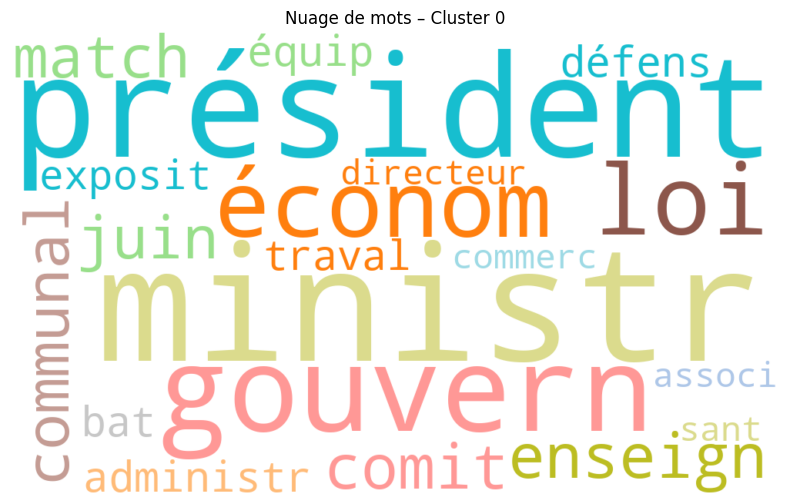

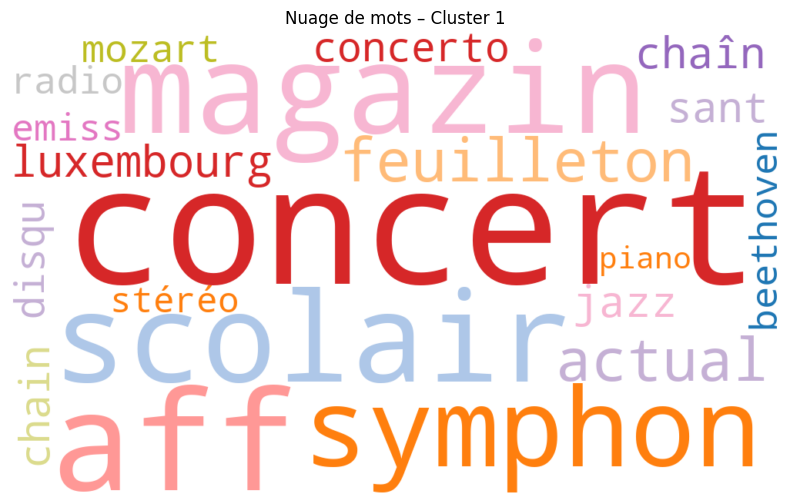

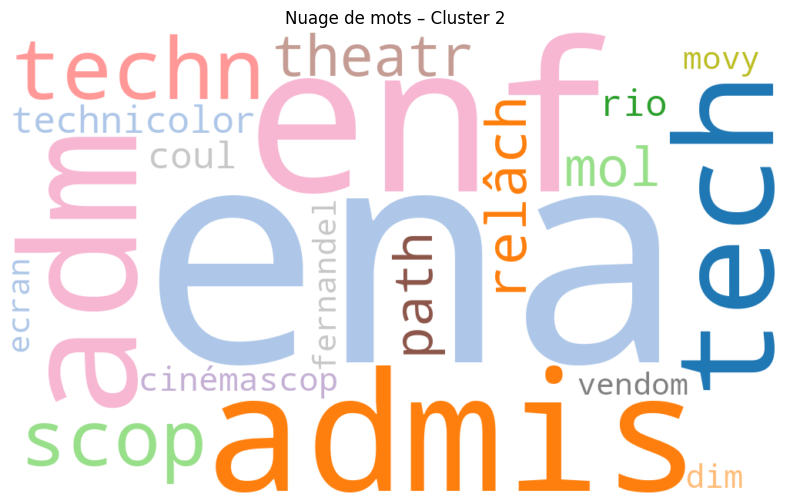

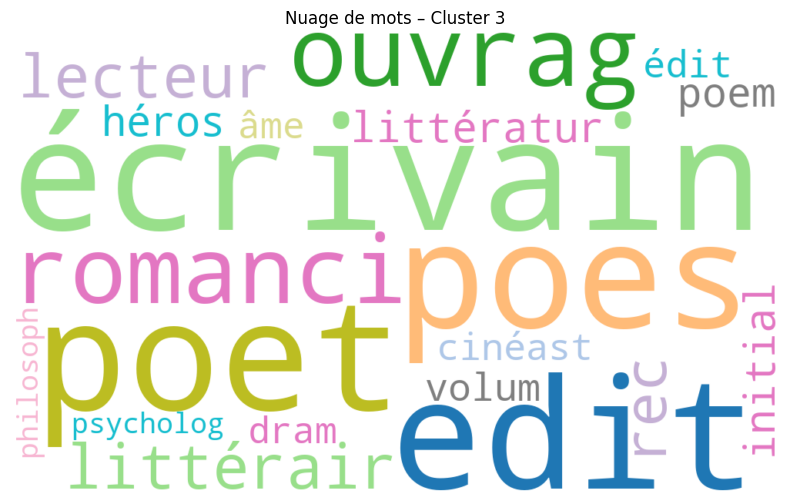

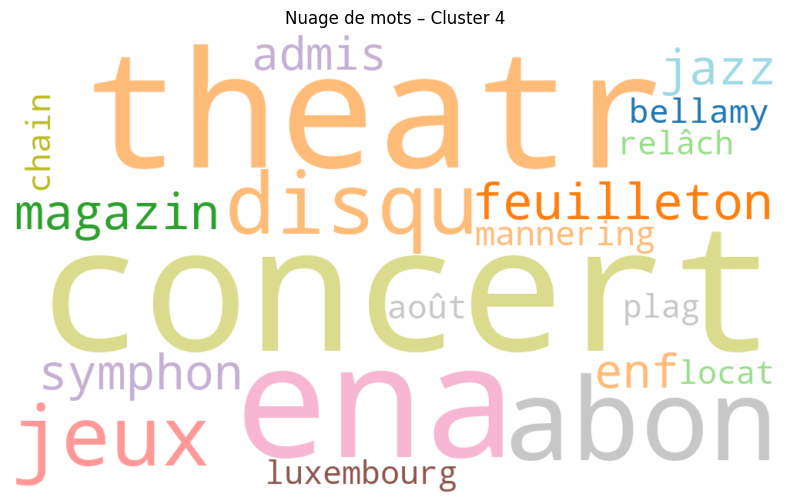

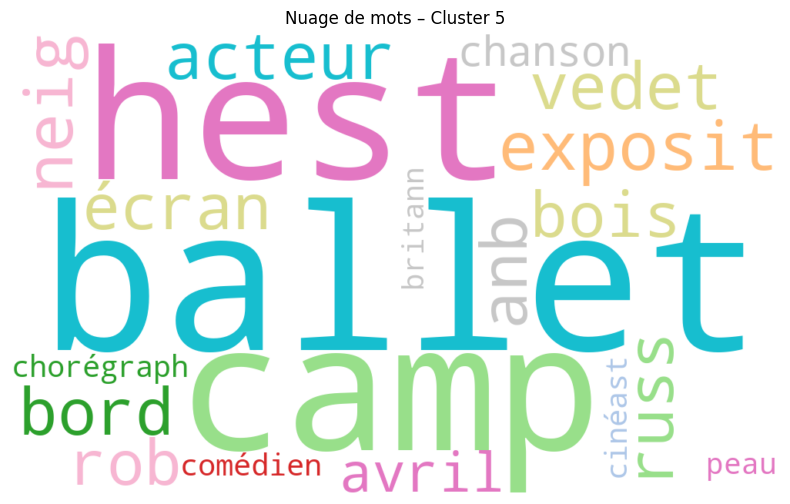

✅ Analyse exportée dans 'analysis_results.pkl'


In [ ]:
# ============================
# 3️⃣ Analyse des entités nommées (NER)
# ============================
import spacy
nlp = spacy.load("fr_core_news_md")


# Extraire entités par cluster
cluster_entities = {}

for c in range(N_CLUSTERS):
    texts_c = [clean_texts[i] for i in range(len(clean_texts)) if clusters[i]==c]
    entities = []
    for doc in nlp.pipe(texts_c, batch_size=10):
        entities.extend([ent.text for ent in doc.ents])
    cluster_entities[c] = collections.Counter(entities).most_common(20)

# Affichage
for c in cluster_entities:
    print(f"\n--- Cluster {c} : Top entités ---")
    pprint(cluster_entities[c])

# ============================
# 4️⃣ Nuages de mots par cluster (déjà fait mais amélioré)
# ============================

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for c in range(N_CLUSTERS):
    pairs = cluster_keywords[c][:50]
    freq = {word: float(score) for word, score in pairs}
    wc = WordCloud(width=1000, height=600, background_color="white", colormap="tab20").generate_from_frequencies(freq)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots – Cluster {c}")
    plt.show()

# ============================
# 5 Export pour mémoire / analyse ultérieure
# ============================

import pickle

data_export = {
    "representative_docs": repr_docs,
    "timeline": timeline,
    "cluster_entities": cluster_entities,
    "cluster_keywords": cluster_keywords,
    "clusters": clusters,
    "clean_files": clean_files,
    "clean_texts": clean_texts
}

with open("analysis_results.pkl", "wb") as f:
    pickle.dump(data_export, f)

print(" Analyse exportée dans 'analysis_results.pkl'")
